In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=0.01, eps=0.05, embedtxt=True, continuous=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital.csv', check_param=True)

INFO:profiler.utility:[0.010649681091308594] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': {'', 'NaN', 'none', 'nan', 'unknown', 'None', '?'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'ProviderNumber': ['e

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.data.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.data.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.data.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.data.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.data.dataset:updated types of State to 'text'
INFO:profiler.data.dataset:updated operators of State to ['equal']
INFO:profiler.data.dataset:updated types of EmergencyService to 'text'
INFO:profiler.data.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.data.dataset:updated types of Score to 'numeric'
INFO:profiler.data.dataset:updated operators of Score to ['equal']
INFO:profiler.data.dataset:updated types of Sample to 'numeric'
INFO:profiler.data.dataset:updated operators of Sample to ['equal']
INFO:profiler.data.dataset:upd

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [5]:
pf.session.load_embedding(save=True, path='data/hospital/', load=True)

INFO:profiler.utility:[0.11952996253967285] Load Embedding start

INFO:profiler.utility:[0.16350078582763672] Load Embedding execution time: 0.04397082328796387



## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [6]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[0.1689457893371582] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 10 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 10, and the bound is 0.00120416
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 17/17 [00:00<00:00, 302.81it/s]
INFO:profiler.data.transformer:Number of training samples: 17000
INFO:profiler.data.transformer:Computing Differences
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0276
INFO:profiler.utility:[1.0024900436401367] Create Training Data execution time: 0.8335442543029785



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [7]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.05, infer_order=True)

INFO:profiler.utility:[1.0069572925567627] Learn Structure start

INFO:profiler.learner:use threshold 0.6159
INFO:profiler.utility:[1.1409368515014648] Learn Structure execution time: 0.13397955894470215



* score: 
    * * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [8]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[1.146503210067749] Get Dependencies start

INFO:profiler.utility:[1.1995007991790771] Get Dependencies execution time: 0.052997589111328125



Stateavg -> MeasureCode (0.058746570588757714)
Stateavg,MeasureCode -> MeasureName (0.09379928381854277)
Stateavg -> Condition (0.1032776160047518)
ProviderNumber -> Address1 (0.02860816404783214)
ProviderNumber,Address1 -> City (0.04986858816196124)
ProviderNumber,Address1,City -> CountyName (0.0401313492550176)
ProviderNumber,Address1,City,CountyName -> PhoneNumber (0.04777986882483734)
ProviderNumber,City,PhoneNumber -> HospitalName (0.04661453005160303)
City -> HospitalOwner (0.07016121203914102)


## 5. Visualization

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


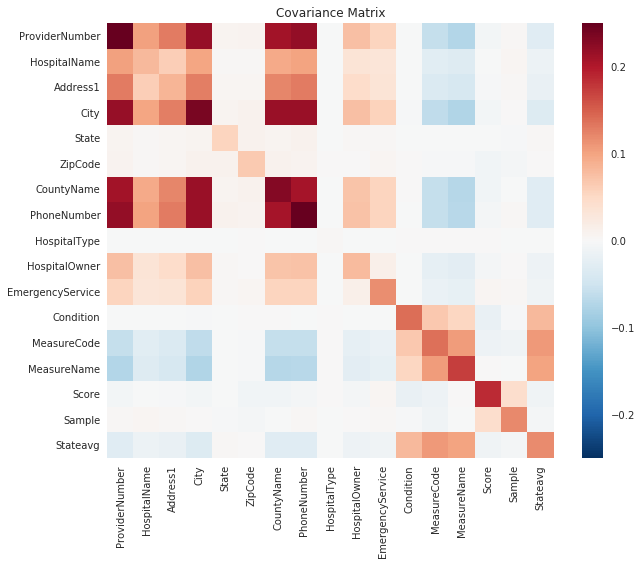

In [9]:
pf.session.visualize_covariance()

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


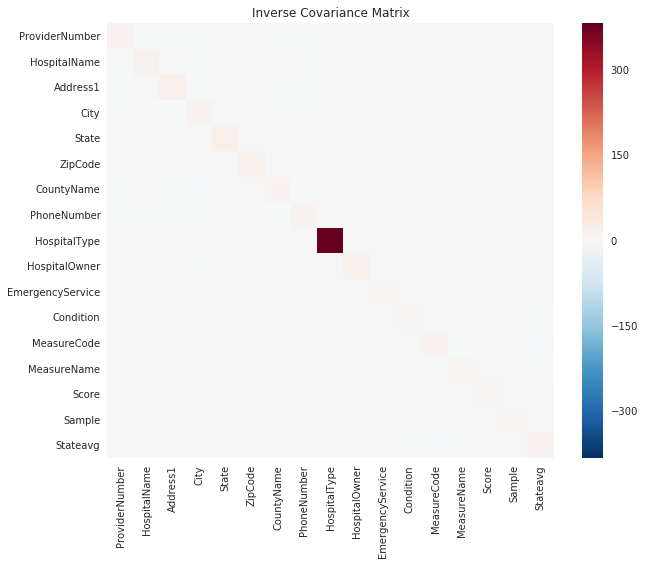

In [10]:
pf.session.visualize_inverse_covariance()

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


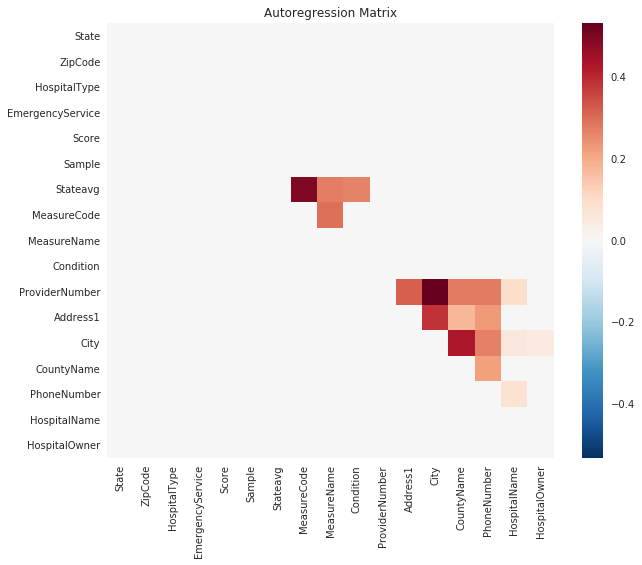

In [11]:
pf.session.visualize_autoregression()

In [14]:
pf.session.timer.get_stat()


,time_point,msg,execution_time
0,0.010650,start: Load Data,0.000000
1,0.071145,end: Load Data,0.060495
2,0.119530,start: Load Embedding,0.000000
3,0.163501,end: Load Embedding,0.043971
4,0.168946,start: Create Training Data,0.000000
5,1.002490,end: Create Training Data,0.833544
6,1.006957,start: Learn Structure,0.000000
7,1.140937,end: Learn Structure,0.133980
8,1.146503,start: Get Dependencies,0.000000
9,1.199501,end: Get Dependencies,0.052998


In [15]:
pf.session.timer.to_csv()